In [2]:
import xarray as xr


In [3]:
# !pip install dask


In [4]:
import os

directory = 'historical_msl'  # Replace with your directory path
file_pattern = 'historical_msl_{}_01_v1.nc'
years = range(1985, 2014)  # 2015 to 2050

# Create a list of file paths
file_paths = [os.path.join(directory, file_pattern.format(year)) for year in years]

# Open multiple files and combine them into a single dataset
ds = xr.open_mfdataset(file_paths, combine='by_coords')


In [5]:
print(ds)


<xarray.Dataset>
Dimensions:               (stations: 43119, time: 29)
Coordinates:
    station_x_coordinate  (stations) float64 dask.array<chunksize=(43119,), meta=np.ndarray>
    station_y_coordinate  (stations) float64 dask.array<chunksize=(43119,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1985-01-01 ... 2013-01-01
  * stations              (stations) uint16 0 1 2 3 ... 43730 43731 43732 43733
Data variables:
    mean_sea_level        (stations, time) float32 dask.array<chunksize=(43119, 1), meta=np.ndarray>
Attributes: (12/35)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            annual_msl
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         Annual mean sea level
    ...                            ...
    time_coverage_start:           1985-01-01
    time_coverage_end:             1985

In [6]:
# to dataframe
df = ds.to_dataframe()

In [7]:
print(df['mean_sea_level'].describe())


count    1.250451e+06
mean     6.730551e-03
std      2.074410e-02
min     -2.160000e-01
25%     -5.000000e-03
50%      2.000000e-03
75%      2.000000e-02
max      1.390000e-01
Name: mean_sea_level, dtype: float64


In [8]:
print(ds.isnull().sum())


<xarray.Dataset>
Dimensions:         ()
Data variables:
    mean_sea_level  int32 dask.array<chunksize=(), meta=np.ndarray>


In [9]:
df.head()

station_x_coordinate  station_y_coordinate  \
stations time                                                     
0        1985-01-01                24.089                34.827   
         1986-01-01                24.089                34.827   
         1987-01-01                24.089                34.827   
         1988-01-01                24.089                34.827   
         1989-01-01                24.089                34.827   

                     mean_sea_level  
stations time                        
0        1985-01-01          -0.017  
         1986-01-01          -0.015  
         1987-01-01          -0.014  
         1988-01-01          -0.013  
         1989-01-01          -0.011

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

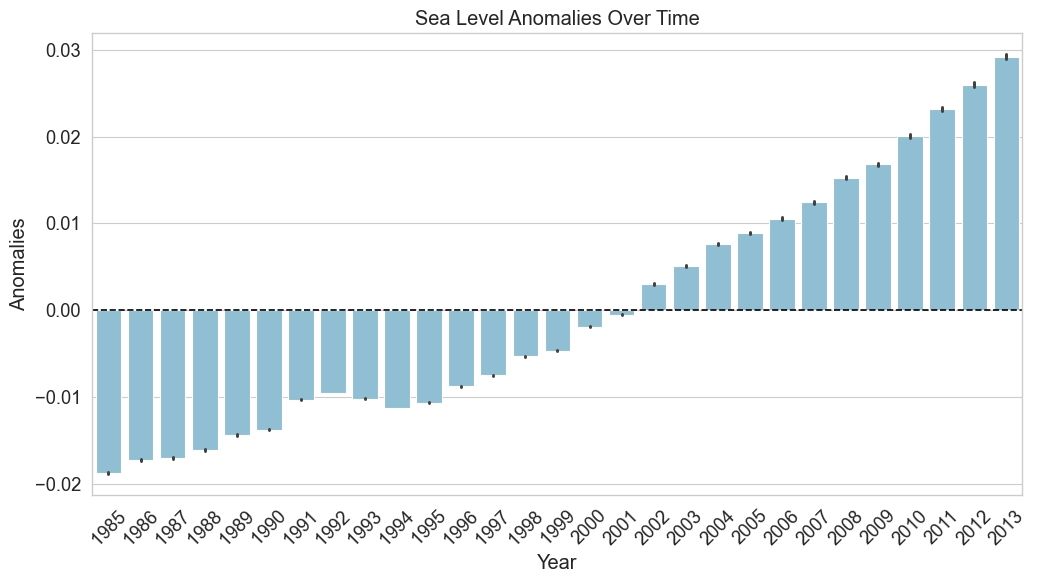

In [17]:


df['year'] = df.index.get_level_values('time').year
# Calculating the anomalies
historical_avg = df['mean_sea_level'].mean()
df['anomalies'] = df['mean_sea_level'] - historical_avg

# Plotting the anomalies
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='anomalies', data=df, color='#85C3DE')
plt.axhline(0, color='k', linestyle='--')
plt.title('Sea Level Anomalies Over Time')
plt.xlabel('Year')
plt.ylabel('Anomalies')
plt.xticks(rotation=45)
plt.show()


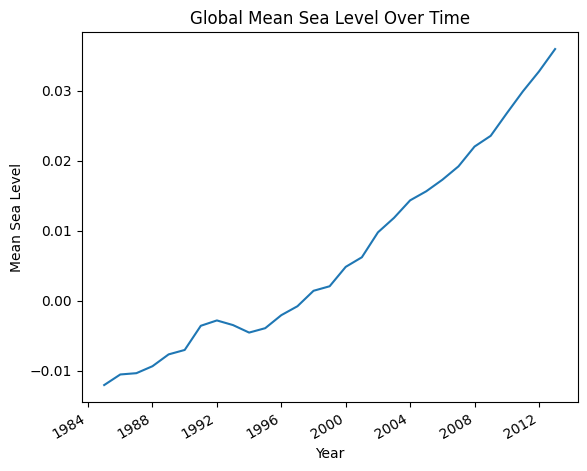

In [9]:
import matplotlib.pyplot as plt

# Assuming 'mean_sea_level' is the variable of interest
# This will calculate the mean sea level across all stations for each time point
mean_sea_level_over_time = ds['mean_sea_level'].mean(dim='stations')

# Now plot this as a simple line plot
mean_sea_level_over_time.plot()
plt.title('Global Mean Sea Level Over Time')
plt.xlabel('Year')
plt.ylabel('Mean Sea Level')
plt.show()

# (Aggregated Across Stations)

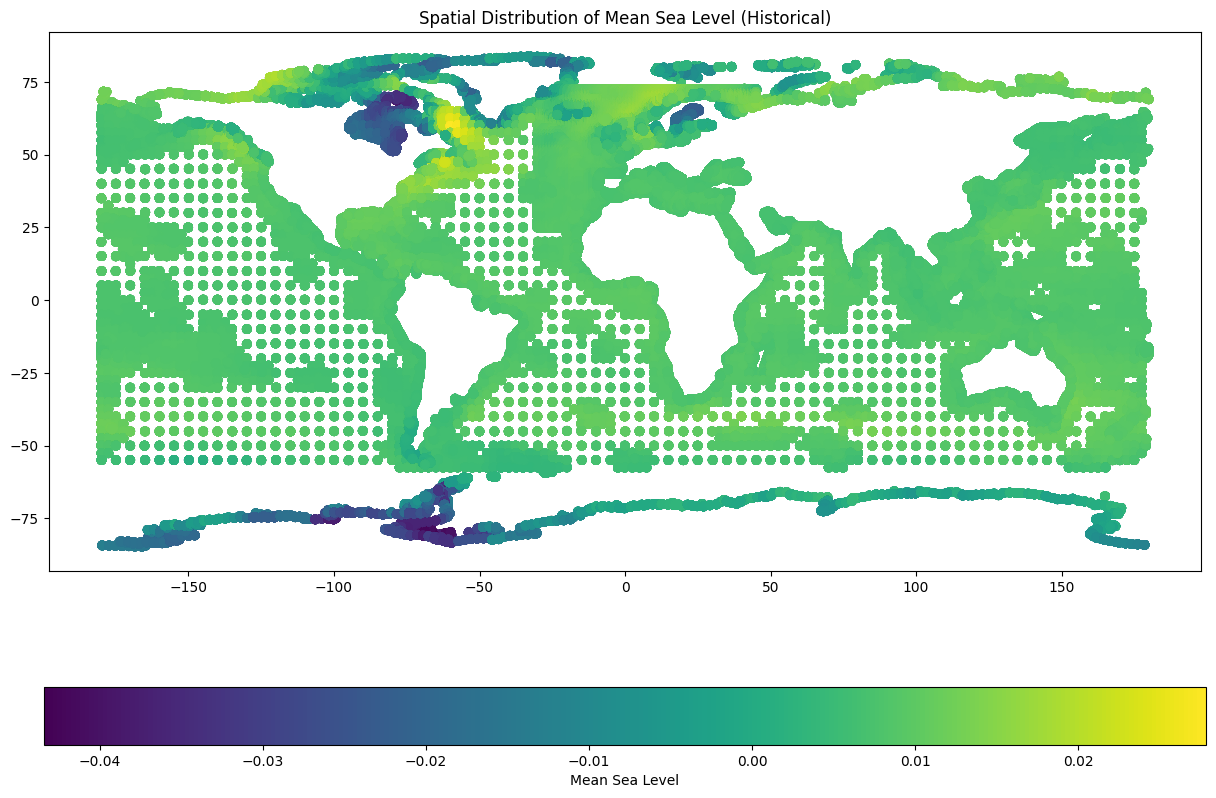

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df.reset_index(),  # Reset index to ensure the DataFrame has a suitable index
    geometry=gpd.points_from_xy(df.station_x_coordinate, df.station_y_coordinate)
)

# Aggregate mean sea level change per station
# This creates a new DataFrame with 'stations' as the index and the mean values as a column
station_mean_sea_level = gdf.groupby('stations')['mean_sea_level'].mean().reset_index()

# Merge this back into the original GeoDataFrame
gdf = gdf.merge(station_mean_sea_level, on='stations', suffixes=('', '_mean'))

# Now when plotting, use the new column with mean values
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='mean_sea_level_mean', ax=ax, legend=True,
         legend_kwds={'label': "Mean Sea Level", 'orientation': "horizontal"})
plt.title('Spatial Distribution of Mean Sea Level (Historical)')
plt.show()


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# If 'df' has a MultiIndex, extract the level with the 'time' information
# Let's assume 'time' is at level 1 of the index
df['year'] = df.index.get_level_values('time').year



# Calculating the anomalies
historical_avg = df['mean_sea_level'].mean()
df['anomalies'] = df['mean_sea_level'] - historical_avg

# Set color condition based on the anomaly values
# colors = ['red' if x > 0 else 'blue' for x in df['anomalies']]

# Plotting the anomalies
plt.figure(figsize=(14, 7))
bars = plt.bar(df['year'], df['anomalies'], color=colors)

# Adding a horizontal line at zero
plt.axhline(0, color='k', linestyle='--')

# Adding titles and labels
plt.title('Sea Level Anomalies Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Anomalies (meters)', fontsize=14)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
# install folium
# !pip install folium

In [12]:
import folium
from folium.plugins import HeatMap

# Assuming `df` is your DataFrame with the appropriate columns
# df = ...

# Prepare the data for the heatmap
# Ensure that the mean sea level data is suitable for use as a weight. It should be a positive number where higher values indicate more intensity
heatmap_data = df[['station_y_coordinate', 'station_x_coordinate', 'mean_sea_level']].dropna()

# Create a map centered around the mean latitude and longitude of your data
map_center = heatmap_data[['station_y_coordinate', 'station_x_coordinate']].mean().values.tolist()
m = folium.Map(location=map_center, zoom_start=5)

# Add the heatmap to the map. Each point in the heatmap_data will have a 'weight' given by the mean sea level
HeatMap(data=heatmap_data.values.tolist(), radius=15).add_to(m)

# Save the map to an HTML file
output_filepath = 'australia_heatmap_historical.html'
m.save(output_filepath)

# Display the link to the saved HTML file if not running in a Jupyter notebook
output_filepath


'australia_heatmap_historical.html'

C:\Users\E\AppData\Local\Temp\ipykernel_69520\1805723909.py:20: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


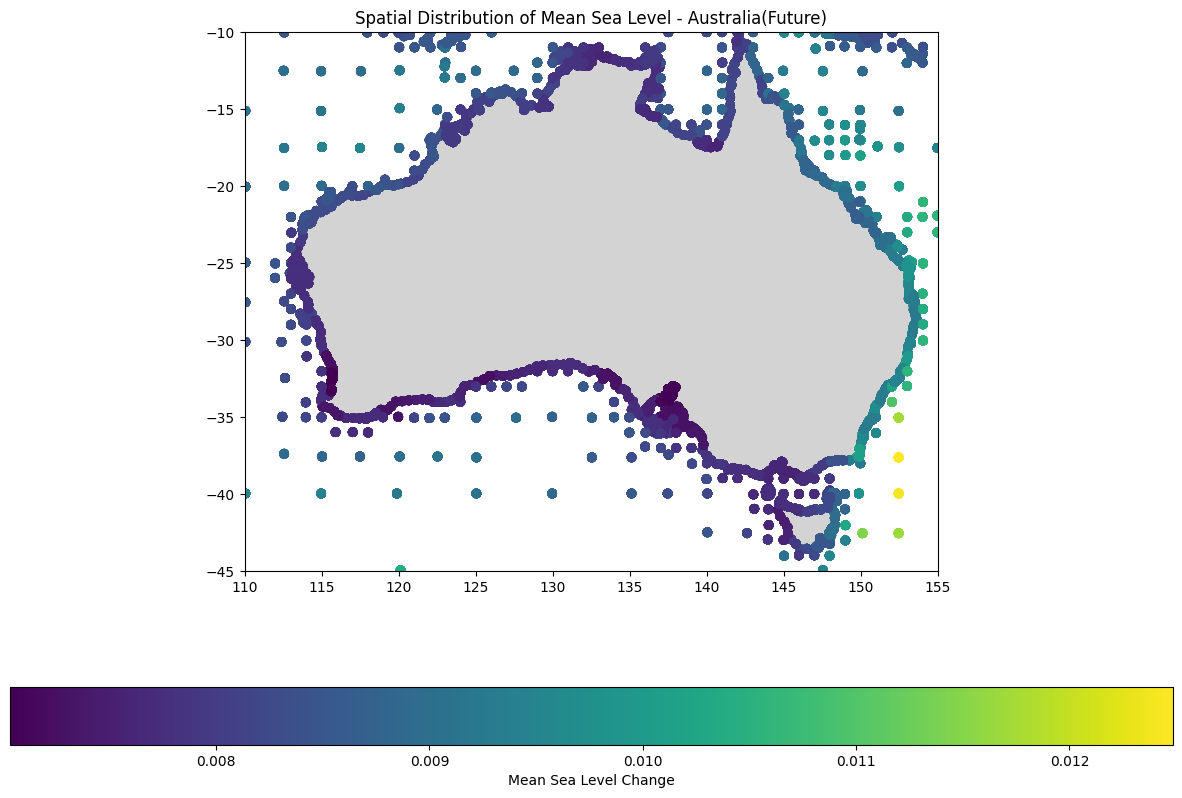

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming df is defined in your code
# df = ...

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df.reset_index(),
    geometry=gpd.points_from_xy(df.station_x_coordinate, df.station_y_coordinate)
)

# Aggregate mean sea level change per station
station_mean_sea_level = gdf.groupby('stations')['mean_sea_level'].mean().reset_index()

# Merge this back into the original GeoDataFrame
gdf = gdf.merge(station_mean_sea_level, on='stations', suffixes=('', '_mean'))

# Read in the built-in GeoPandas world dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for Australia in the world GeoDataFrame
australia = world[world.name == "Australia"]

# Plot the world base map with Australia highlighted
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='white', edgecolor='black')
australia.plot(ax=ax, color='lightgrey')

# Zoom into Australia's bounding box (use the approximate coordinates)
ax.set_xlim([110, 155])
ax.set_ylim([-45, -10])

# Filter the GeoDataFrame for points within Australia's bounding box
gdf_australia = gdf.cx[110:155, -45:-10]

# Plot mean sea level change data over Australia
gdf_australia.plot(column='mean_sea_level_mean', ax=ax, legend=True,
                   legend_kwds={'label': "Mean Sea Level Change", 'orientation': "horizontal"})

plt.title('Spatial Distribution of Mean Sea Level - Australia(Future)')
plt.show()




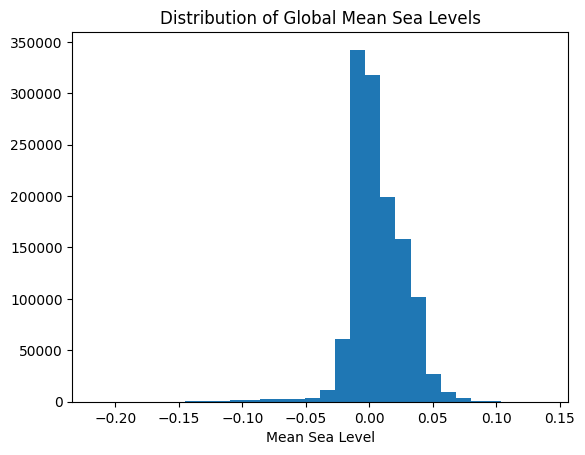

In [14]:
ds['mean_sea_level'].plot.hist(bins=30)
plt.title('Distribution of Global Mean Sea Levels')
plt.xlabel('Mean Sea Level')
plt.show()


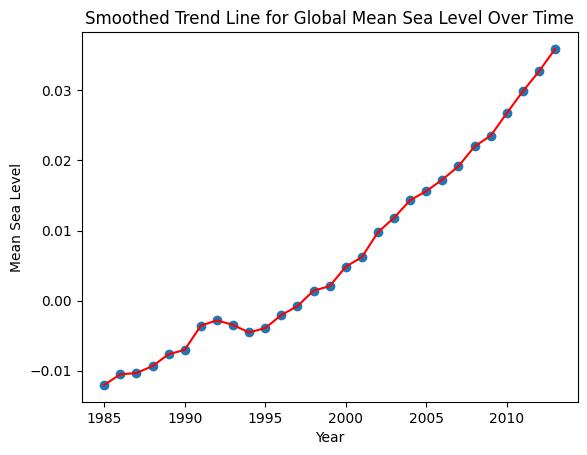

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# If 'df' has a MultiIndex, extract the level with the 'time' information
# Let's assume 'time' is at level 1 of the index
df['year'] = df.index.get_level_values('time').year

# Now that we have a 'year' column, we can proceed with the LOWESS model
# You may need to group by the 'year' and take the mean if the data has multiple entries per year
yearly_mean = df.groupby('year')['mean_sea_level'].mean().reset_index()

smoothed = lowess(yearly_mean['mean_sea_level'], yearly_mean['year'], frac=0.1)

# Create the plot
plt.plot(yearly_mean['year'], yearly_mean['mean_sea_level'], 'o')
plt.plot(smoothed[:, 0], smoothed[:, 1], 'r-')
plt.title('Smoothed Trend Line for Global Mean Sea Level Over Time')
plt.xlabel('Year')
plt.ylabel('Mean Sea Level')
plt.show()



In [1]:
# Calculating the anomalies
historical_avg = df['mean_sea_level'].mean()
df['anomalies'] = df['mean_sea_level'] - historical_avg

# Plotting the anomalies
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='anomalies', data=df, color='blue')
plt.axhline(0, color='k', linestyle='--')
plt.title('Sea Level Anomalies Over Time')
plt.xlabel('Year')
plt.ylabel('Anomalies')
plt.xticks(rotation=45)
plt.show()


NameError: name 'df' is not defined

Text(0.5, 0, 'Mean Sea Level')

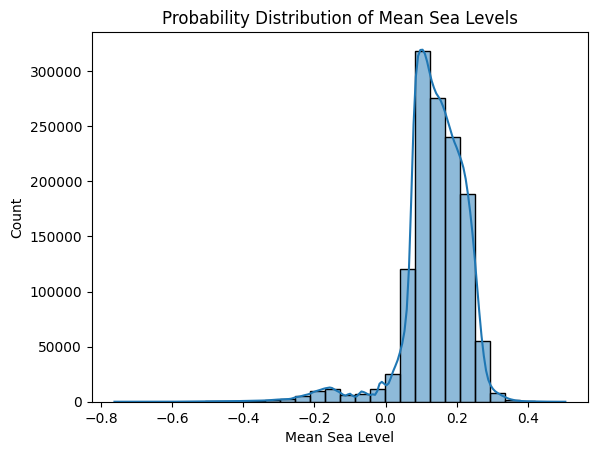

In [17]:
sns.histplot(df['mean_sea_level'], bins=30, kde=True)
plt.title('Probability Distribution of Mean Sea Levels')
plt.xlabel('Mean Sea Level')

In [19]:
df.head()

station_x_coordinate  station_y_coordinate  \
stations time                                                     
0        2021-01-01                24.089                34.827   
         2022-01-01                24.089                34.827   
         2023-01-01                24.089                34.827   
         2024-01-01                24.089                34.827   
         2025-01-01                24.089                34.827   

                     mean_sea_level  year  anomalies  
stations time                                         
0        2021-01-01           0.079  2021  -0.060414  
         2022-01-01           0.084  2022  -0.055414  
         2023-01-01           0.089  2023  -0.050414  
         2024-01-01           0.094  2024  -0.045414  
         2025-01-01           0.099  2025  -0.040414

In [ ]:
ds.close()